# Copy for ksp of this page:
https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/ex_python_plot_zarr.html


### install block
im not convinced we need this

In [20]:
# !pip install numpy
# !pip install Cartopy
# !pip install pandas
# !pip install matplotlib
# !pip install xarray
# !pip install requests
# !pip install netCDF4
# !pip install metpy
# !pip install h5py
# !pip install numcodecs
# !pip install s3fs
# !pip install google
# !pip install google-cloud-storage
# !pip install azure-storage-blob
# !pip install zarr
# !pip install pytz

### Setup

In [21]:
#location: 
point_lat = 39.58148838130895
point_lon = -105.94259648925797

# Date: [YYYYMMDD] must be in this format. Example is for Jan 8, 2021
date = '20210108'

# Hour: [00-23]z must be in the two digit format  i.e. 06 or 19
hr = '00'

# Level: 
level = 'surface'

# Variable:
var = 'TMP'

data_url = f'hrrrzarr/sfc/{date}/{date}_{hr}z_fcst.zarr/{level}/{var}/{level}/{var}/'

In [22]:
import s3fs
import numcodecs as ncd
import numpy as np
import datetime
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fs = s3fs.S3FileSystem(anon=True)

### Load Hrrr chunk index and set up projections

In [23]:
chunk_index = xr.open_zarr(s3fs.S3Map("s3://hrrrzarr/grid/HRRR_chunk_index.zarr", s3=fs))

In [24]:
import cartopy.crs as ccrs

# This is the projection the HRRR grid uses.
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

x, y = projection.transform_point(point_lon, point_lat, ccrs.PlateCarree())

nearest_point = chunk_index.sel(x=x, y=y, method="nearest")
fcst_chunk_id = f"0.{nearest_point.chunk_id.values}"
print(fcst_chunk_id)

0.3.4


### retreive data

In [25]:
%%time
def retrieve_data(s3_url):
    with fs.open(s3_url, 'rb') as compressed_data: # using s3fs
        buffer = ncd.blosc.decompress(compressed_data.read())

        dtype = "<f2"
        if "surface/PRES" in s3_url: # surface/PRES is the only variable with a larger data type
            dtype = "<f4"

        chunk = np.frombuffer(buffer, dtype=dtype)
        
        entry_size = 150*150
        num_entries = len(chunk)//entry_size

        if num_entries == 1: # analysis file is 2d
            data_array = np.reshape(chunk, (150, 150))
        else:
            data_array = np.reshape(chunk, (num_entries, 150, 150))

    return data_array


data = retrieve_data(data_url + fcst_chunk_id)
print(data.shape)

(48, 150, 150)
CPU times: user 11.9 ms, sys: 58 µs, total: 12 ms
Wall time: 202 ms


### Assess 

In [26]:
gridpoint_forecast = data[:, nearest_point.in_chunk_y, nearest_point.in_chunk_x]


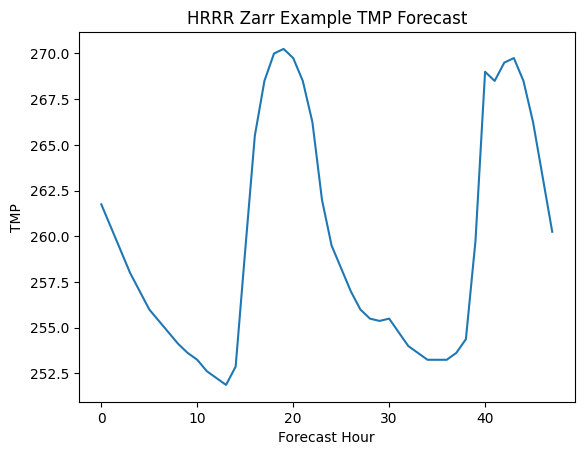

In [27]:
plt.title('HRRR Zarr Example %s Forecast' %(var))
plt.xlabel('Forecast Hour')
plt.ylabel(var)
plt.plot(gridpoint_forecast)

In [29]:
%%time
anl_chunk_id = nearest_point.chunk_id.values # doesn't have the 0.

start = datetime.datetime.strptime(date + hr, '%Y%m%d%H')
forecast_length = len(gridpoint_forecast)
gridpoint_analysis = []

for time_delta in range(forecast_length):
    # construct the aws path
    analysis_time = start + datetime.timedelta(hours=time_delta)
    url = analysis_time.strftime(f'hrrrzarr/sfc/%Y%m%d/%Y%m%d_%Hz_anl.zarr/{level}/{var}/{level}/{var}/{anl_chunk_id}')
    
    # download the chunk from s3
    hrrr_data_anl = retrieve_data(url)
    
    # append the data we need
    gridpoint_analysis.append(hrrr_data_anl[nearest_point.in_chunk_y, nearest_point.in_chunk_x])

CPU times: user 195 ms, sys: 3.98 ms, total: 199 ms
Wall time: 4.07 s


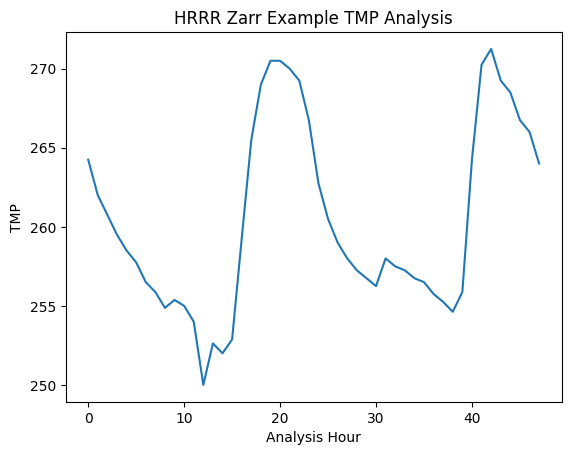

In [30]:
# Plot the data
plt.title('HRRR Zarr Example %s Analysis' %(var))
plt.xlabel('Analysis Hour')
plt.ylabel(var)
plt.plot(gridpoint_analysis)

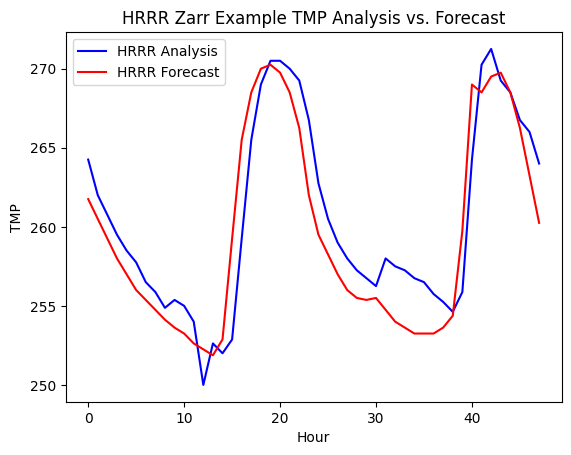

In [31]:
plt.title('HRRR Zarr Example %s Analysis vs. Forecast' %(var))
plt.xlabel('Hour')
plt.ylabel(var)
plt.plot(gridpoint_analysis, color='blue', label='HRRR Analysis')
plt.plot(gridpoint_forecast, color='red', label='HRRR Forecast')
plt.legend()